In [2]:
import torch as pt
import numpy as np
import numpy.random as rnd
from tqdm import tqdm
import matplotlib.pyplot as plt
import scipy.integrate as itg
from IPython import display
import time
import functools as ft

import scipy.interpolate as interp

import mechsamp as ms
from importlib import reload

%matplotlib inline

7it [00:26,  3.71s/it]


-0.9513592959213144 tensor(-41.8601, grad_fn=<DivBackward1>)


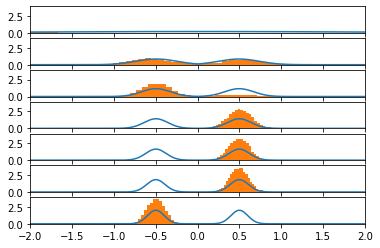

In [3]:
meas_std = .1

y = .5
gaussianDist = pt.distributions.Normal(0.,2.)

priorLL = lambda x : gaussianDist.log_prob(x)

noiseDist = pt.distributions.Normal(0.,meas_std)
def measurent(x):
    return pt.abs(x) + pt.randn_like(x)
measureLL = lambda x,y : noiseDist.log_prob(y-pt.abs(x))



def thermo_loss(x,theta):
    prior = priorLL(x)
    like = measureLL(x,y)
    return -theta * like - prior

def joint_pdf(x,theta):
    loss = thermo_loss(x,theta)
    joint = pt.exp(-loss)
    return joint
    
def joint_pdf_np(x,theta):
    x_pt = pt.tensor(x,dtype=pt.float)
    joint = joint_pdf(x_pt,theta)
    return joint.detach().numpy()
    

x_plot = pt.linspace(-2,2,200)

NumTheta = 7
NumSteps = 10000
eta = .001
Theta = pt.linspace(0,1,NumTheta)

fig,ax = plt.subplots(NumTheta,1,sharex=True,sharey=True)

Z_num = []
LikeEst = []


for i,theta in tqdm(enumerate(Theta)):
    # Numerically evaluate the posterior
    z,_ = itg.quad(joint_pdf_np,-np.inf,np.inf,args=(theta,))
    Z_num.append(z)
    pdf = joint_pdf(x_plot,theta)/z

    # Now try to sample from it. 
    x = pt.randn(1,requires_grad=True)

    X = []
    
    sampler = ms.FOLangevin(thermo_loss,eta)~
    
    for step in range(NumSteps):~
        x = sampler.step(x,theta)
        X.append(x)
        
    X = pt.cat(X)
    LikeEst.append(measureLL(X,y).mean())
    
    X_np = X.detach().numpy()
    ax[i].plot(x_plot,pdf)
    ax[i].hist(X_np,density=True,bins=30)
    ax[i].set_xlim([x_plot.min(),x_plot.max()])
    
    
Z_num = np.array(Z_num)
Z_dist = Z_num /  (np.sum(Z_num) * (Theta[1]-Theta[0]).detach().numpy())
LikeEst = pt.stack(LikeEst)
z_est = pt.trapz(LikeEst,Theta)
print(np.log(Z_num[-1]),z_est)

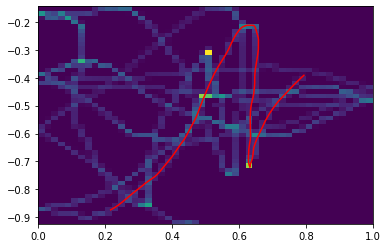

  8%|▊         | 84491/1000000 [01:03<11:28, 1330.30it/s]


KeyboardInterrupt: 

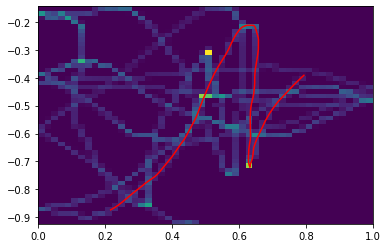

In [10]:
# Trying the joint sampling method for sampling both x and theta simultaneously
reload(ms)
def joint_thermo_loss(z):
    x,theta = z
    return thermo_loss(x,theta)

A = pt.tensor([[0,-1.],
               [0,1.]])
b = pt.tensor([0.,1.])


metropolis = False
eta = 1e-4
NumSteps = int(1e6)
plot_period = int(1e4)

# First order
#x = pt.cat([pt.randn((1,)),pt.rand((1,))]).detach().clone().requires_grad_(True)
#sampler = ms.FOLangevin(joint_thermo_loss,eta,A=A,b=b)

# Second order
x = pt.cat([pt.randn((1,)),pt.rand((1,)),pt.randn((2,))]).detach().clone().requires_grad_(True)
sampler = ms.SOLangevin(joint_thermo_loss,eta,A=A,b=b)

# HMC

X = []
LL = []
plt.figure()
for step in tqdm(range(NumSteps)):
    x_next = sampler.step(x)
    
    if metropolis:
        # Metropolis test
        loss_next = joint_thermo_loss(x_next[:2])+.5 * pt.sum(x_next[2:]**2)
        loss_cur = joint_thermo_loss(x[:2]) + .5 * pt.sum(x[2:]**2)
        log_alpha = (loss_cur - loss_next).detach().numpy()
        if np.log(rnd.rand()) <= log_alpha:
            x = x_next.detach().clone().requires_grad_(True)
    else:
        x = x_next.detach().clone().requires_grad_(True)
    
    X.append(x)
    
    if ((step+1) % plot_period) == 0:
        plt.clf()
        
        X_np = pt.stack(X).detach().numpy()
        theta = X_np[:,1]
        omega = X_np[:,0]

        plt.hist2d(theta,omega,bins=50,density=True)

        plt.plot(theta[-plot_period:],omega[-plot_period:],'r')
        display.clear_output(wait=True)
        display.display(plt.gcf())
        time.sleep(0.5)
        
    
X = pt.stack(X)
theta = X[:,1]
omega = X[:,0]

plt.hist2d(theta.detach().numpy(),omega.detach().numpy(),bins=50,density=True)

theta,ind = pt.sort(theta)
omega = omega[ind]



X_np = X.detach().numpy()

Z_est = pt.trapz(measureLL(omega,y),theta)

plt.figure()
print(np.log(Z_num[-1]),Z_est,)
plt.plot(Theta,Z_dist)
plt.hist(X_np[:,1],bins=30,density=True);

In [65]:
type(log_alpha

array(0.37406182, dtype=float32)

In [58]:
NumBins = 50
tol = 1e-6
binbounds = pt.linspace(0-tol,1+tol,NumBins+1)
binstarts = binbounds[:-1]
binstops = binbounds[1:]

N = len(theta)

LL_val = []
for start,stop in zip(binstarts,binstops):
    tup = pt.where(pt.logical_and(theta>= start,theta < stop))
    ind = tup[0]
    LL = measureLL(omega[ind],y).mean()
    LL_val.append(LL)
    
logZest = pt.stack(LL_val).sum() * (stop-start)
print(logZest)

tensor(-0.2242, grad_fn=<MulBackward0>)


In [36]:
ind[0]

tensor([448333, 448334, 448335,  ..., 499997, 499998, 499999])

In [10]:
?pt.logical_and

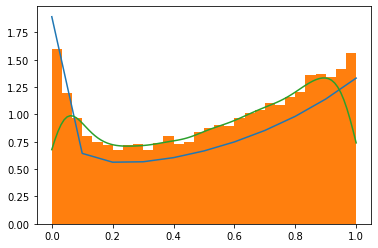

In [45]:
kernel = lambda x : pt.exp(-.5 * x**2) / np.sqrt(2*np.pi)

def kde(x,theta,h):
    D = pt.outer(x,pt.ones_like(theta)) - pt.outer(pt.ones_like(x),theta)
    K = kernel(D/h)/h
    return pt.mean(K,dim=1)


theta_plot = pt.linspace(0,1,100)
pdf_plot = kde(theta_plot,theta,.05)
plt.plot(Theta,Z_dist)
plt.hist(X_np[:,1],bins=30,density=True)
plt.plot(theta_plot.detach().numpy(),pdf_plot.detach().numpy())

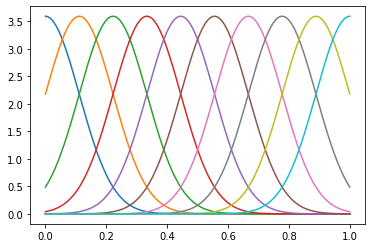

In [64]:
import cvxpy as cvx
import scipy.stats as st

theta_np = theta.detach().numpy()

centers = np.linspace(0,1,10)
#h = np.sqrt(centers[1]-centers[0])
h = (centers[1]-centers[0])

theta_plot = np.linspace(0,1,1000)

for center in centers:
    pdf = st.norm.pdf(theta_plot,loc=center,scale=h)
    plt.plot(theta_plot,pdf)


In [50]:
?st.norm.pdf

In [30]:
U_np = measureLL(omega,y).detach().numpy()
theta_np = theta.detach().numpy()
print(itg.trapz(U_np,theta_np))
print(itg.simps(U_np,theta_np))

-0.8376336
nan


/home/andy/.local/lib/python3.8/site-packages/scipy/integrate/_quadrature.py:372: RuntimeWarning: divide by zero encountered in true_divide
  h0divh1 = h0 / h1
/home/andy/.local/lib/python3.8/site-packages/scipy/integrate/_quadrature.py:372: RuntimeWarning: invalid value encountered in true_divide
  h0divh1 = h0 / h1
/home/andy/.local/lib/python3.8/site-packages/scipy/integrate/_quadrature.py:373: RuntimeWarning: divide by zero encountered in true_divide
  tmp = hsum/6.0 * (y[slice0]*(2-1.0/h0divh1) +
/home/andy/.local/lib/python3.8/site-packages/scipy/integrate/_quadrature.py:374: RuntimeWarning: divide by zero encountered in true_divide
  y[slice1]*hsum*hsum/hprod +
/home/andy/.local/lib/python3.8/site-packages/scipy/integrate/_quadrature.py:374: RuntimeWarning: invalid value encountered in true_divide
  y[slice1]*hsum*hsum/hprod +
/home/andy/.local/lib/python3.8/site-packages/scipy/integrate/_quadrature.py:373: RuntimeWarning: invalid value encountered in add
  tmp = hsum/6.0 * (y[s

100%|██████████| 1000/1000 [01:02<00:00, 16.06it/s]


-0.35172800606765864 tensor(0.0941)


(array([1.15332775, 0.77194845, 0.74744215, 0.70915106, 0.77654338,
        0.71221435, 0.78879653, 0.70915106, 0.65248024, 0.64482202,
        0.6999612 , 0.77807503, 0.79492311, 0.82096105, 0.8087079 ,
        0.88835338, 0.88682174, 0.97718872, 0.98484694, 1.06449241,
        1.092062  , 1.14720117, 1.12116323, 1.21612514, 1.21306186,
        1.30955541, 1.47497294, 1.51632732, 1.59290951, 1.88851675]),
 array([-9.80942429e-04,  3.24168444e-02,  6.58146312e-02,  9.92124180e-02,
         1.32610205e-01,  1.66007992e-01,  1.99405779e-01,  2.32803565e-01,
         2.66201352e-01,  2.99599139e-01,  3.32996926e-01,  3.66394713e-01,
         3.99792499e-01,  4.33190286e-01,  4.66588073e-01,  4.99985860e-01,
         5.33383647e-01,  5.66781434e-01,  6.00179220e-01,  6.33577007e-01,
         6.66974794e-01,  7.00372581e-01,  7.33770368e-01,  7.67168155e-01,
         8.00565941e-01,  8.33963728e-01,  8.67361515e-01,  9.00759302e-01,
         9.34157089e-01,  9.67554875e-01,  1.00095266e+00]

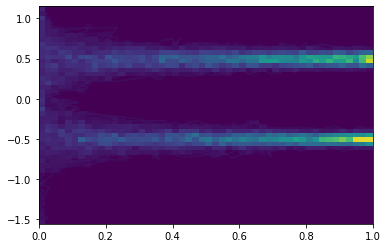

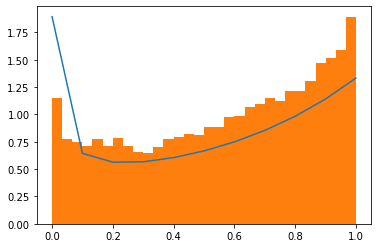

In [71]:
# Same thing as above, but just with HMC  instead.
reload(ms)
def joint_thermo_loss(z):
    x,theta = z
    return thermo_loss(x,theta)

A = pt.tensor([[0,-1.],
               [0,1.]])
b = pt.tensor([0.,1.])



NumSteps = 1000


x = pt.cat([pt.randn((1,)),pt.rand((1,)),pt.randn((2,))]).detach().clone().requires_grad_(True)
sampler = ms.HMCSampler(joint_thermo_loss,A=A,b=b)

# HMC

X_list = []
Time_list  = []
t = 0
for step in tqdm(range(NumSteps)):
    
    X_traj,Time_traj = sampler.step(x,tstart=t)
    x = X_traj[-1].detach().clone().requires_grad_(True)
    t = Time_traj[-1]
    
    X_list.append(X_traj)
    Time_list.append(Time_traj)
    
X = pt.cat(X_list,dim=0)
Time = pt.cat(Time_list)
    
theta = X[:,1]
omega = X[:,0]

plt.plot(theta,omega,alpha=.1)




X_np = X.detach().numpy()

Time_np = Time.detach().numpy()

f = interp.interp1d(Time_np,X_np,axis=0)
Time_lin = np.linspace(Time_np[0],Time_np[-1],len(Time_np))
X_interp = f(Time_lin)




X_interp_pt = pt.tensor(X_interp,dtype=pt.float)




theta = X_interp_pt[:,1]
omega = X_interp_pt[:,0]

theta,ind = pt.sort(theta)
omega = omega[ind]

Z_est = pt.trapz(measureLL(omega,y),theta)

plt.hist2d(X_interp[:,1],X_interp[:,0],bins=50,density=True)
plt.figure()
print(np.log(Z_num[-1]),Z_est)

plt.plot(Theta,Z_dist)
plt.hist(X_interp[:,1],bins=30,density=True)



